In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping
image_size = 256 # can we read this from the imagery?

import matplotlib.pyplot as plt

2025-02-03 12:47:47.415414: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
df_train, df_val = image_dataset_from_directory('/content/gdrive/MyDrive/Colab Notebooks/SDSS/imagery',
                                 validation_split = 0.2,
                                 subset='both',
                                 seed = 0,
                                 batch_size = 100,
                                 image_size = (image_size, image_size))
class_names = df_train.class_names
num_classes = len(class_names)
print(class_names)

Found 4097 files belonging to 4 classes.
Using 3278 files for training.
Using 819 files for validation.
['elliptical', 'irregular', 'lenticular', 'spiral']


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

df_train = df_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
df_val = df_val.cache().prefetch(buffer_size=AUTOTUNE)

epochs=150
patience=10

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(image_size,
                                  image_size,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:

def train_save_plot_model(model, epochs, patience, df_train, df_val, model_filepath):
  checkpoint_path = "models/{}/model_checkpoints/{}.weights.h5".format(model_filepath, model_filepath)
  checkpoint_dir = os.path.dirname(checkpoint_path)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
  early_stopping = EarlyStopping(
    patience=patience,
    restore_best_weights=True,
)
  model.compile(optimizer = 'adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  history = model.fit(df_train, validation_data = df_val, epochs=epochs, callbacks=[early_stopping, cp_callback])

  model_path = "models/{}/{}.keras".format(model_filepath, model_filepath)
  model.save(model_path)

  history_df = pd.DataFrame(history.history)
  history_df.to_csv('models/{}/{}_history.csv'.format(model_filepath, model_filepath))
  history_df.loc[:, ['loss', 'val_loss']].plot();
  return history

Epoch 1/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5482 - loss: 1.0823
Epoch 1: saving model to models/base/model_checkpoints/base.weights.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 1517s 5s/step - accuracy: 0.5487 - loss: 1.0809 - val_accuracy: 0.6593 - val_loss: 0.7970
Epoch 2/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6546 - loss: 0.8102
Epoch 2: saving model to models/base/model_checkpoints/base.weights.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.6545 - loss: 0.8103 - val_accuracy: 0.6484 - val_loss: 0.7746
Epoch 3/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6275 - loss: 0.7719
Epoch 3: saving model to models/base/model_checkpoints/base.weights.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.6276 - loss: 0.7720 - val_accuracy: 0.6630 - val_loss: 0.7866
Epoch 4/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6486 - loss: 0.7915
Epoch 4: saving model to models/base/model_checkpoints/base.weights.h5
103/103 ━━━━━━━━━

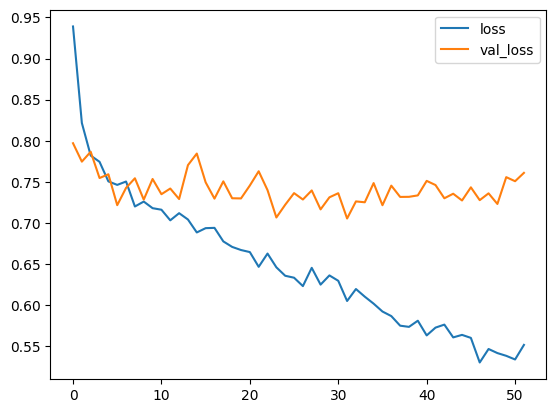

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])
train_save_plot_model(model, epochs, patience, df_train, df_val, 'base')


Epoch 1/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5521 - loss: 1.7047
Epoch 1: saving model to models/smaller_base/model_checkpoints/smaller_base.weights.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 806s 4s/step - accuracy: 0.5525 - loss: 1.6990 - val_accuracy: 0.6276 - val_loss: 0.8237
Epoch 2/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6422 - loss: 0.8250
Epoch 2: saving model to models/smaller_base/model_checkpoints/smaller_base.weights.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.6423 - loss: 0.8250 - val_accuracy: 0.6520 - val_loss: 0.8067
Epoch 3/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6505 - loss: 0.8090
Epoch 3: saving model to models/smaller_base/model_checkpoints/smaller_base.weights.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.6505 - loss: 0.8089 - val_accuracy: 0.6606 - val_loss: 0.8014
Epoch 4/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6560 - loss: 0.7961
Epoch 4: saving model to models/smaller_b

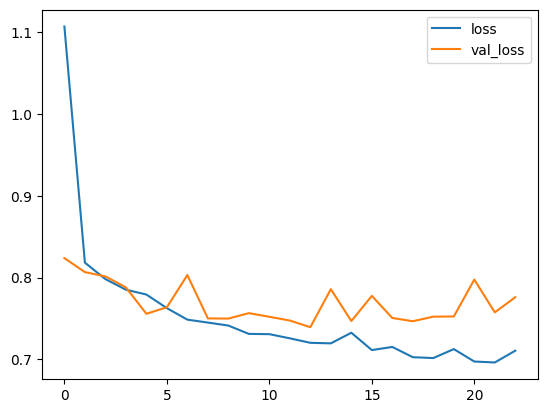

In [ ]:
# less sophisticated base
model1 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

train_save_plot_model(model1, epochs, patience, df_train, df_val, 'smaller_base')

In [13]:
# more sophisticated head
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

train_save_plot_model(model2, epochs, patience, df_train, df_val, 'bigger_head')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5299 - loss: 1.1160
Epoch 1: saving model to models/bigger_head/model_checkpoints/bigger_head.weights.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.5304 - loss: 1.1151 - val_accuracy: 0.6642 - val_loss: 0.8272
Epoch 2/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6278 - loss: 0.8982
Epoch 2: saving model to models/bigger_head/model_checkpoints/bigger_head.weights.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.6279 - loss: 0.8980 - val_accuracy: 0.6667 - val_loss: 0.8207
Epoch 3/150
  3/103 ━━━━━━━━━━━━━━━━━━━━ 3:53 2s/step - accuracy: 0.5174 - loss: 0.9052

KeyboardInterrupt: 

In [18]:
# more dropout
model3 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes)
])

train_save_plot_model(model3, epochs, patience, df_train, df_val, 'more_dropout')

Epoch 1/150


KeyboardInterrupt: 

Epoch 1/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4526 - loss: 1.2456
Epoch 1: saving model to models/more_dropout_bigger_batch/model_checkpoints/more_dropout_bigger_batch.weights.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 350s 10s/step - accuracy: 0.4554 - loss: 1.2401 - val_accuracy: 0.6178 - val_loss: 0.8896
Epoch 2/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6195 - loss: 0.8905
Epoch 2: saving model to models/more_dropout_bigger_batch/model_checkpoints/more_dropout_bigger_batch.weights.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 339s 9s/step - accuracy: 0.6195 - loss: 0.8900 - val_accuracy: 0.6447 - val_loss: 0.8373
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6416 - loss: 0.8434
Epoch 3: saving model to models/more_dropout_bigger_batch/model_checkpoints/more_dropout_bigger_batch.weights.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 305s 9s/step - accuracy: 0.6416 - loss: 0.8428 - val_accuracy: 0.6618 - val_loss: 0.7814
Epoch 4/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy

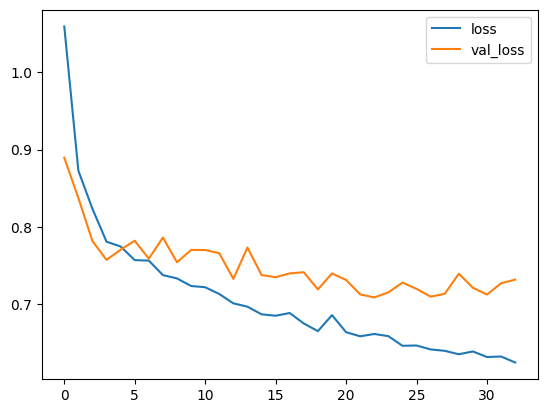

In [19]:
train_save_plot_model(model3, epochs, patience, df_train, df_val, 'more_dropout_bigger_batch')